In [1]:
%matplotlib inline

In [2]:
import numpy as np # Who does not use Numpy?
import re, sys, os, math
from scipy import signal

import cma
from skimage.util import compare_images
from tifffile import imsave, imread
from sklearn.metrics import mean_squared_error

import matplotlib
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

import imageio # Save a GIF animation

import SimpleITK as sitk # Load a DICOM file
import spekpy as sp # Create the beam spectrum
import gvxrPython3 as gvxr

Read the DICOM file

In [3]:
reader = sitk.ImageFileReader()
reader.SetImageIO("GDCMImageIO")
reader.SetFileName("data/DX000000")
reader.LoadPrivateTagsOn()
reader.ReadImageInformation()    
volume = reader.Execute()
real_image = sitk.GetArrayFromImage(volume)[0]

In [4]:
# meta_data_keys = volume.GetMetaDataKeys()

# print("DICOM fields:")
# for key in meta_data_keys:
#     print(key, volume.GetMetaData(key))

In [5]:
# def cleanTags(raw_string):
#     regular_expression = re.compile('<.*?>')
#     clean_text = re.sub(regular_expression, '', raw_string)
#     return clean_text


In [6]:



# field = volume.GetMetaData("0033|1022")

# for item in field.split("\n"):
#     if "KV" in item:
#         kv = float(cleanTags(item))
        

# print(kv)


In [7]:
spacing = volume.GetSpacing()[0:2]
size = volume.GetSize()[0:2]

In [8]:
kVp = float(volume.GetMetaData("0018|0060"))
print("Peak kilo voltage output of the x-ray generator used: ", kVp)

Peak kilo voltage output of the x-ray generator used:  89.9


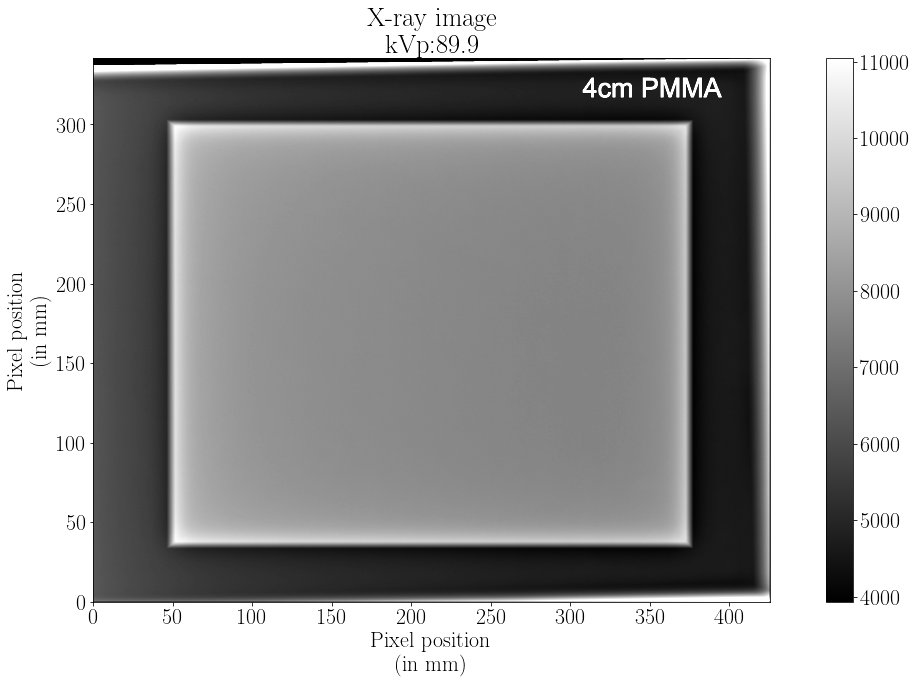

In [9]:
plt.figure(figsize= (20,10))
xrange=range(real_image.shape[1])
yrange=range(real_image.shape[0])

plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")
plt.title("X-ray image\nkVp:" + str(kVp))
plt.imshow(real_image, cmap="gray", 
           vmin=3934, vmax = 11045,
           extent=[0,(real_image.shape[1]-1)*spacing[0],0,(real_image.shape[0]-1)*spacing[1]])
plt.colorbar(orientation='vertical')

In [10]:
# source_detector_distance = float(volume.GetMetaData("0018|1110"))
# print("Distance Source to Detector: ", kVp)

In [11]:
# source_object_distance = float(volume.GetMetaData("0018|1111"))
# print("Distance Source to Patient: ", source_object_distance)

In [12]:
window_size =  [800, 450]
source_position = [0.0, 0.0, 96.0, "cm"]
detector_position = [0.0, 0.0, -4.0, "cm"]
detector_up = [0, 1, 0]

In [13]:
# Create an OpenGL context
print("Create an OpenGL context:",
    str(window_size[0]) + "x" + str(window_size[1])
);
gvxr.createOpenGLContext();
gvxr.setWindowSize(
    window_size[0],
    window_size[1]
);


Create an OpenGL context: 800x450


In [14]:
def createBlock(x, y, z, w, h, r):
    # Remove all the geometries from the whole scenegraph
    gvxr.removePolygonMeshesFromSceneGraph()

    # Make a cube
    gvxr.makeCube("PMMA block", 1.0, "mm")

    # Translation vector
    gvxr.translateNode("PMMA block", x, y, z, "cm")

    # Rotation angle
    gvxr.rotateNode("PMMA block", r, 0, 0, 1)

    # Scaling factors
    gvxr.scaleNode("PMMA block", w, h, 40);

    # Apply the transformation matrix so that we can save the corresponding STL file
    gvxr.applyCurrentLocalTransformation("PMMA block");

    # Set the matrix's material properties
    gvxr.setCompound("PMMA block", "C5O2H8")
    gvxr.setDensity("PMMA block", 1.18, "g/cm3")

    # Add the matrix to the X-ray renderer
    gvxr.addPolygonMeshAsInnerSurface("PMMA block")

In [15]:
x = y = 0
z = 0
w = 330
h = 270
r = 0
createBlock(x, y, z, w, h, r)

In [16]:
# Set up the beam
print("Set up the beam")
print("\tSource position:", source_position)
gvxr.setSourcePosition(
    source_position[0],
    source_position[1],
    source_position[2],
    source_position[3]
);

gvxr.usePointSource();

focal_spot_size = volume.GetMetaData("0018|1413")
# gvxr.setFocalSpot(focal_spot_size, focal_spot_size, focal_spot_size, "mm");
print("size of focal spot (in mm):", focal_spot_size)

Set up the beam
	Source position: [0.0, 0.0, 96.0, 'cm']
size of focal spot (in mm): 11.653


# Get the spectrum from the DICOM file

In [17]:
spectrum = {};

s = sp.Spek(kvp=kVp)
# s.filter(filter_material, filter_thickness_in_mm) # Filter by 4 mm of Al
unit = "keV"
k, f = s.get_spectrum(edges=True) # Get the spectrum

min_energy = sys.float_info.max
max_energy = -sys.float_info.max

for energy, count in zip(k, f):
    count = round(count)

    if count > 0:

        max_energy = max(max_energy, energy)
        min_energy = min(min_energy, energy)

        if energy in spectrum.keys():
            spectrum[energy] += count
        else:
            spectrum[energy] = count

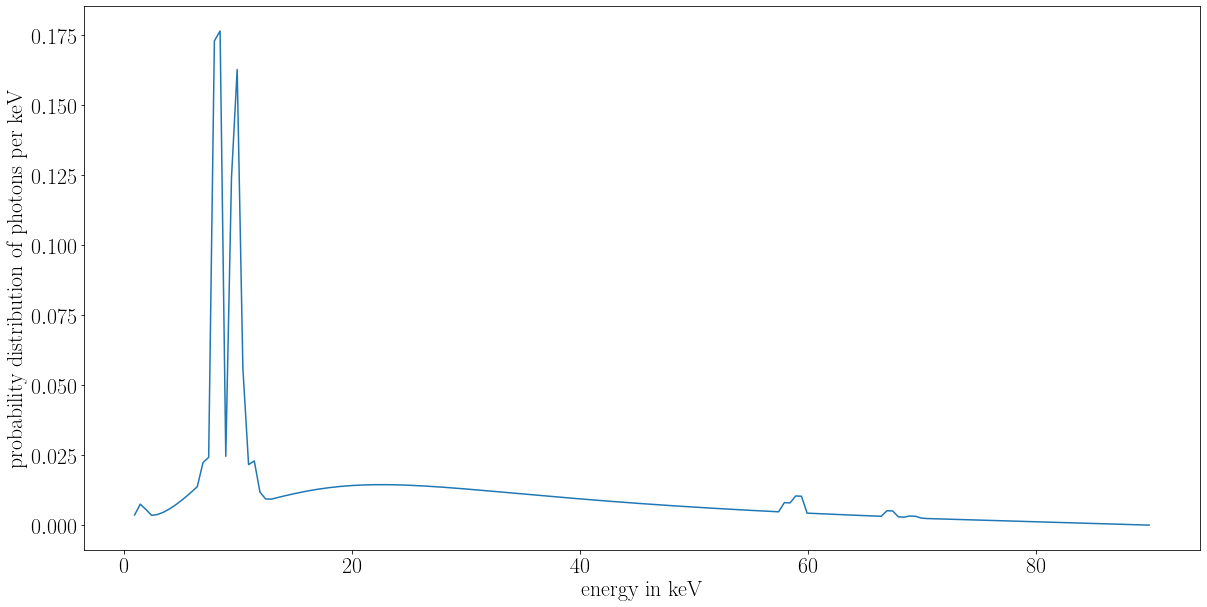

In [18]:
# get the integral nb of photons
nbphotons=0.
energy1 = -1.
energy2 = -1.

for energy in spectrum.keys():
    
    if energy1<0:
        energy1 = float(energy)
    elif energy2<0:
        energy2 = float(energy)
    nbphotons += float(spectrum[energy])
sampling = (energy2-energy1)

# get spectrum
data = []
for energy in spectrum.keys():
    source = [float(energy),float(spectrum[energy])/(nbphotons*sampling)]
    data.append(source)

# plot spectrum
plt.figure(figsize= (20,10))

data_array = np.array(data)

energies, counts = data_array.T
plt.plot(energies, counts)
plt.xlabel('energy in keV')
plt.ylabel('probability distribution of photons per keV')

plt.savefig("/plots/spectrum.pdf")

In [19]:
number_of_energy_bins = 25
count_set = signal.resample(counts, number_of_energy_bins)
energy_set = np.linspace(energies.min(), energies.max(), number_of_energy_bins, endpoint=True)

In [20]:
# for energy in spectrum.keys():
#     count = spectrum[energy]
#     gvxr.addEnergyBinToSpectrum(energy, unit, count);

for energy, count in zip(energy_set, count_set):
    gvxr.addEnergyBinToSpectrum(energy, unit, count);

In [21]:
# Set up the detector
print("Set up the detector");
print("\tDetector position:", detector_position)
gvxr.setDetectorPosition(
    detector_position[0],
    detector_position[1],
    detector_position[2],
    detector_position[3]
);

print("\tDetector up vector:", detector_up)
gvxr.setDetectorUpVector(
    detector_up[0],
    detector_up[1],
    detector_up[2]
);

Set up the detector
	Detector position: [0.0, 0.0, -4.0, 'cm']
	Detector up vector: [0, 1, 0]


In [22]:
print("\tDetector number of pixels:", size)
gvxr.setDetectorNumberOfPixels(
    size[0],
    size[1]
);

print("\tPixel spacing:", spacing)
gvxr.setDetectorPixelSize(
    spacing[0],
    spacing[1],
    "mm"
);

	Detector number of pixels: (3040, 2442)
	Pixel spacing: (0.14, 0.14)


In [23]:
gvxr.displayScene()

gvxr.useLighing()
gvxr.useWireframe()
gvxr.setSceneRotationMatrix([0.43813619017601013, 0.09238918125629425, -0.8941444158554077, 0.0,
                             0.06627026945352554, 0.9886708855628967, 0.13463231921195984, 0.0,
                             0.8964602947235107, -0.11824299395084381, 0.4270564019680023, 0.0,
                             0.0, 0.0, 0.0, 1.0])
gvxr.setZoom(1639.6787109375)

gvxr.displayScene()

In [24]:
screenshot = gvxr.takeScreenshot()

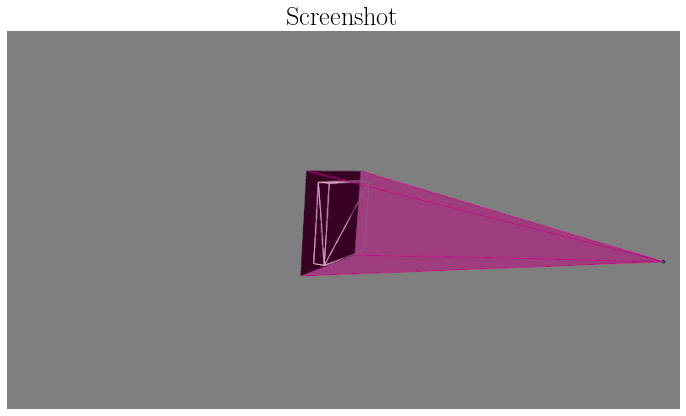

In [25]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off.pdf')
plt.savefig('plots/screenshot-beam-off.png')

# Optimise the size and position of the block

In [26]:
def standardisation(image):
    return (image - image.mean()) / image.std();

In [27]:
def zncc(i1, i2):
    return (np.mean(np.multiply(i1, i2))) / 2.0;

In [28]:
def objectiveFunction(parameters):
    
    global best_fitness
    global best_fitness_id
    global fitness_function_call_id
    global evolution_zncc
    global evolution_parameters
    
    # Retrieve the parameters
    x, y, z, w, h, r = parameters
    
    # Update the block geometry
    createBlock(x, y, z, w, h, r)
    
    # Compute an X-ray image
    x_ray_image = np.array(gvxr.computeXRayImage())
    
    # Compute the negative image as it is the case for the real image
    x_ray_image *= -1.
    
    # Zero-mean, unit-variance normalistion
    x_ray_image = standardisation(x_ray_image)
    
    # Return the objective
    objective = math.sqrt(mean_squared_error(real_image, x_ray_image))

    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        
        gvxr.displayScene()
        screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

        gvxr.saveSTLfile("PMMA block", "outputs/PMMA_block_" + str(best_fitness_id) + ".stl")
        np.savetxt("outputs/PMMA_block_" + str(best_fitness_id) + ".dat", [x, y, z, w, h, r], header='x,y,z,w,h,r')
        imsave("outputs/xray_" + str(best_fitness_id) + ".tif", x_ray_image.astype(np.single))
        imsave("outputs/screenshot_" + str(best_fitness_id) + ".tif", screenshot)
    
        zncc_value = zncc(real_image, x_ray_image)
        evolution_zncc.append([fitness_function_call_id, zncc_value])
        evolution_parameters.append([fitness_function_call_id, x, y, z, w, h, r])
        
        best_fitness = objective
        best_fitness_id += 1
    
    fitness_function_call_id += 1
    
    return objective

In [29]:
# Zero-mean, unit-variance normalistion
real_image = standardisation(real_image)

In [30]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/PMMA_block.dat") and os.path.isfile("outputs/evolution_zncc.dat"):
    
    temp = np.loadtxt("outputs/PMMA_block.dat")
    x = temp[0]
    y = temp[1]
    z = temp[2]
    w = temp[3]
    h = temp[4]
    r = temp[5]
    
    # Update the block geometry
    createBlock(x, y, z, w, h, r)

    evolution_zncc = np.loadtxt("outputs/PMMA_block.dat")

else:
    # Optimise
    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-2)
    opts['tolx'] = 1e-2
    opts['bounds'] = [[-20, -20, detector_position[2] + 4, 280, 220, -90],
                      [10, 10, source_position[2] - 4, 380, 320, 90]]
    opts['CMA_stds'] = []

    for min_val, max_val in zip(opts['bounds'][0], opts['bounds'][1]):
        opts['CMA_stds'].append(abs(max_val - min_val) * 0.15)

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    fitness_function_call_id = 0
    evolution_zncc = []
    evolution_parameters = []
    
    # Optimise
    es = cma.CMAEvolutionStrategy([x, y, z, w, h, r], 0.5, opts)
    es.optimize(objectiveFunction)

    # Save the parameters
    x, y, z, w, h, r = es.result.xbest
    np.savetxt("outputs/PMMA_block.dat", [x, y, z, w, h, r], header='x,y,z,w,h,r')

    # Update the block geometry
    createBlock(x, y, z, w, h, r)
    gvxr.saveSTLfile("PMMA block", "outputs/PMMA_block_" + str(best_fitness_id) + ".stl")

    evolution_zncc = np.array(evolution_zncc)
    np.savetxt("outputs/evolution_zncc.dat", evolution_zncc, header='t,ZNCC')

    evolution_parameters = np.array(evolution_parameters)
    np.savetxt("outputs/evolution_parameters.dat", evolution_parameters, header='t,x,y,z,w,h,r')

    # Release memory
    del es;

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=288430, Tue Sep 21 14:59:24 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.099494410524056e+00 1.0e+00 4.73e-01  2e+00  1e+01 0:16.0
    2     18 9.785492839653941e-01 1.3e+00 3.82e-01  2e+00  9e+00 0:36.0
    3     27 1.022061469394294e+00 1.3e+00 3.16e-01  1e+00  8e+00 0:43.5
    4     36 1.014485591498683e+00 1.4e+00 2.75e-01  1e+00  6e+00 0:50.9
    5     45 1.055408642425521e+00 1.4e+00 2.62e-01  1e+00  6e+00 0:58.5
    6     54 1.035132877406669e+00 1.4e+00 2.44e-01  9e-01  5e+00 1:06.0
    7     63 9.903584465405844e-01 1.5e+00 2.32e-01  9e-01  5e+00 1:13.5
    8     72 9.584102970547786e-01 1.4e+00 2.13e-01  7e-01  4e+00 1:25.2
    9     81 9.311846414869703e-01 1.6e+00 2.01e-01  7e-01  4e+00 1:36.8
   11     99 9.745523417804447e-01 1.6e+00 1.65e-01  5e-01  3e+00 1:51.7
   13    117 9.261083985362207e-01 1.8e+00 1.38e-01  4e-01  2e+00 2:10.8
   14    126 9.201429155366689e-01 

In [31]:
print("Block centre (in cm):", x, y, z)
print("Block size (in cm):", w / 10.0, h / 10.0, 4)
print("Rotation angle (in degrees):", r)

Block centre (in cm): -0.1274939305907692 0.2280224911316946 0.8194215731548381
Block size (in cm): 30.811991331560836 25.050496678694763 4
Rotation angle (in degrees): 0.030888412098671585


Text(0, 0.5, 'Rotation angle (in degrees)')

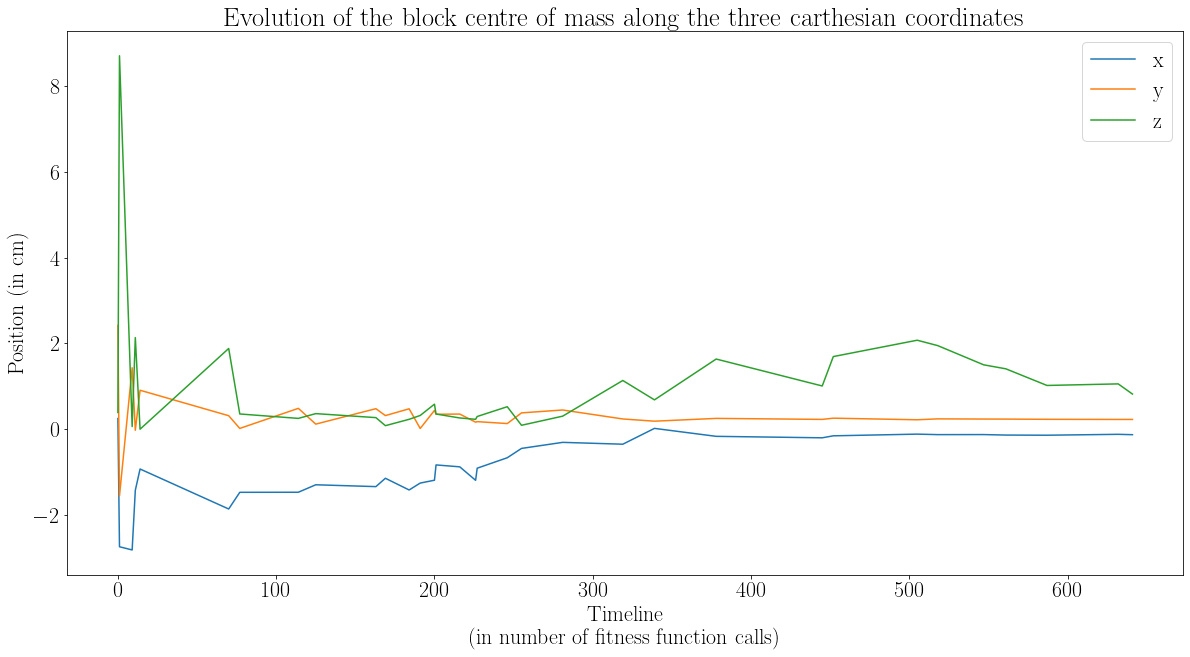

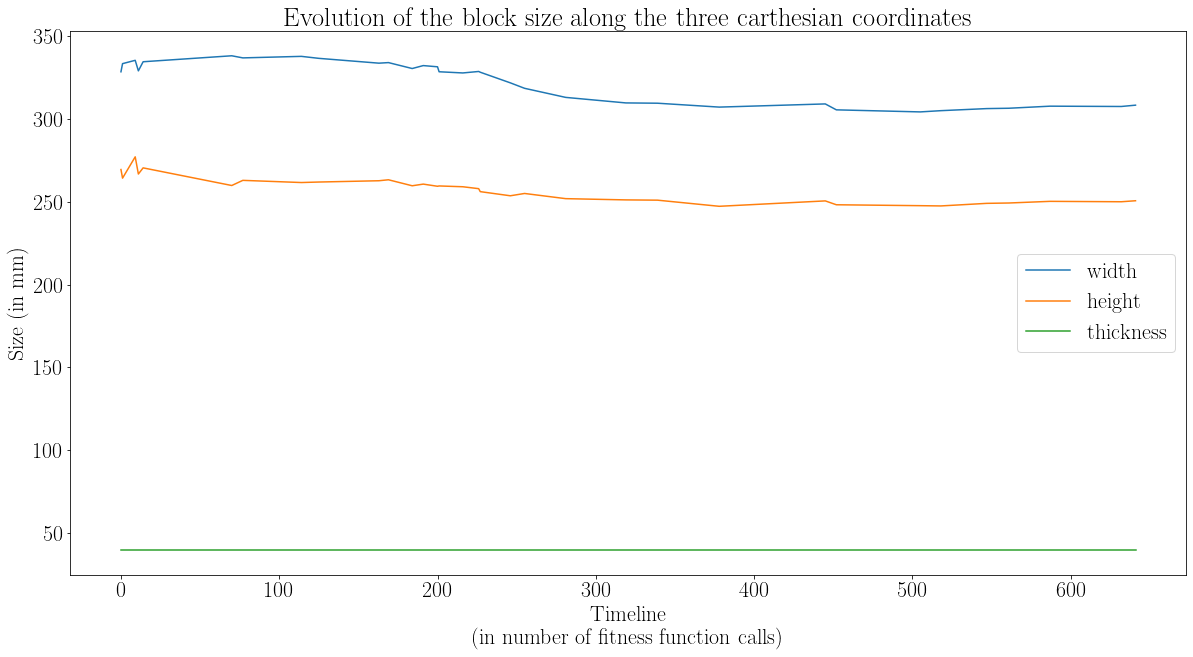

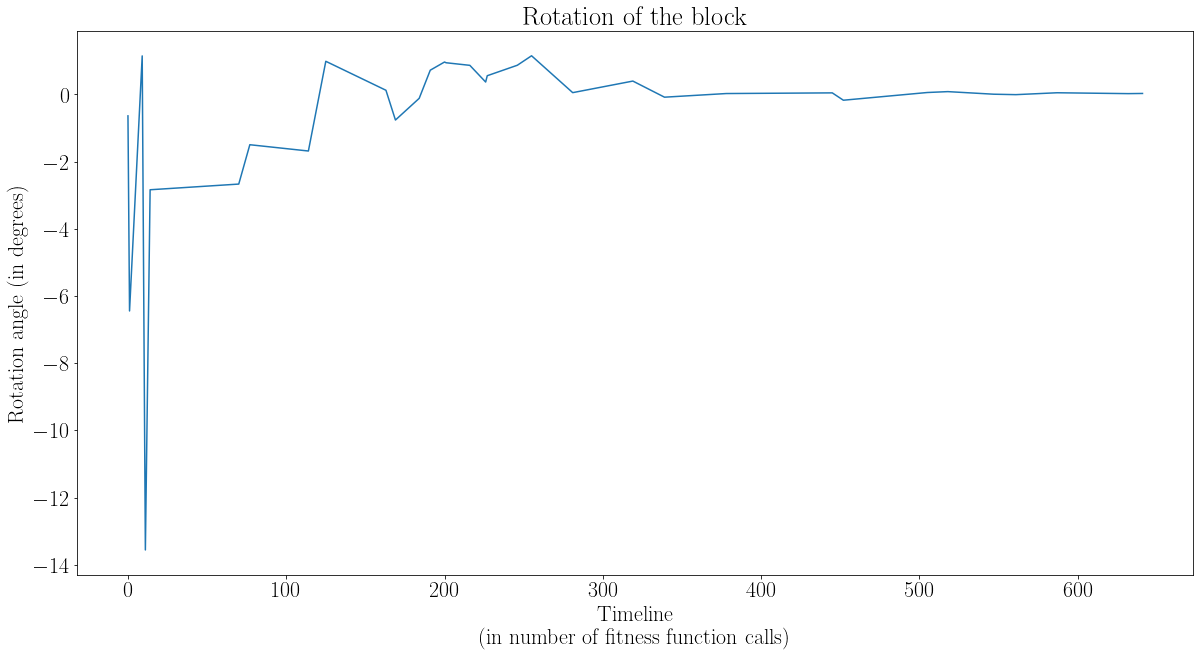

In [32]:
evolution_parameters = np.array(evolution_parameters)

plt.figure(figsize= (20,10))
plt.title("Evolution of the block centre of mass along the three carthesian coordinates")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,1], label="x")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,2], label="y")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,3], label="z")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Position (in cm)")
plt.legend()

plt.figure(figsize= (20,10))
plt.title("Evolution of the block size along the three carthesian coordinates")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,4], label="width")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,5], label="height")
plt.plot(evolution_parameters[:,0], 40 * np.ones(evolution_parameters.shape[0]), label="thickness")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Size (in mm)")
plt.legend()

plt.figure(figsize= (20,10))
plt.title("Rotation of the block")
plt.plot(evolution_parameters[:,0], evolution_parameters[:,6], label="angle")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("Rotation angle (in degrees)")

In [33]:
# Compute an X-ray image
x_ray_image = np.array(gvxr.computeXRayImage())

gvxr.displayScene()

# Compute the negative image as it is the case for the real image
x_ray_image *= -1.

# Zero-mean, unit-variance normalistion
x_ray_image = standardisation(x_ray_image)

Text(0, 0.5, 'ZNCC\n(in \\%)')

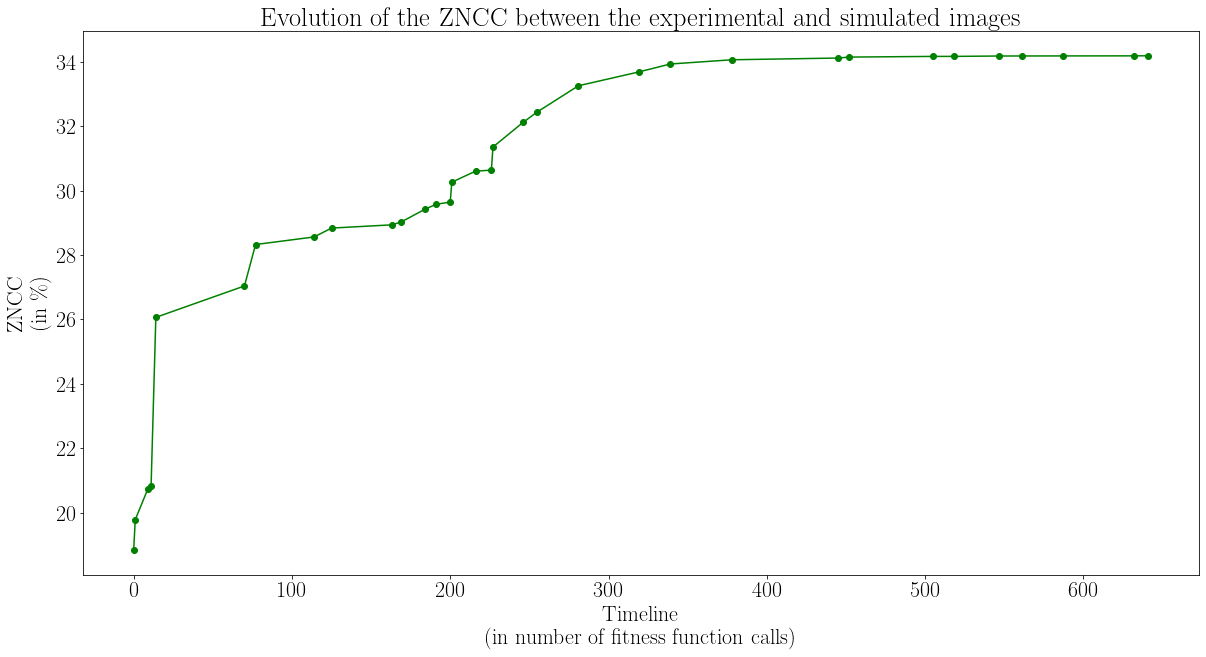

In [34]:
plt.figure(figsize= (20,10))
plt.title("Evolution of the ZNCC between the experimental and simulated images")
plt.plot(evolution_zncc[:,0], 100.0 * evolution_zncc[:,1], "go-")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("ZNCC\n(in \%)")

In [35]:
# gvxr.renderLoop()
# print(gvxr.getZoom())
# print(gvxr.getSceneRotationMatrix())

In [36]:
def compareImages(real_image, x_ray_image, colorbar=True, rows = 1, cols = 3):
    comp_equalized = compare_images(real_image, x_ray_image, method='checkerboard');
    
#     plt.figure(figsize= (20,10))

    # plt.suptitle("Image simulated using gVirtualXRay without the energy response of the detector", y=1.02)

    plt.subplot(rows, cols, 1)
    plt.imshow(real_image, cmap="gray", vmin=-1, vmax=1,
               extent=[0,(real_image.shape[1]-1)*spacing[0],0,(real_image.shape[0]-1)*spacing[1]])
    if colorbar:
        plt.colorbar(orientation='horizontal')
    plt.title("Experimental image")
    plt.xlabel("Pixel position\n(in mm)")
    plt.ylabel("Pixel position\n(in mm)")

    plt.subplot(rows, cols, 2)
    plt.imshow(x_ray_image, cmap="gray", vmin=-1, vmax=1,
               extent=[0,(real_image.shape[1]-1)*spacing[0],0,(real_image.shape[0]-1)*spacing[1]])
    if colorbar:
        plt.colorbar(orientation='horizontal')
    plt.title("Simulated image")
    plt.xlabel("Pixel position\n(in mm)")
    plt.ylabel("Pixel position\n(in mm)")

    plt.subplot(rows, cols, 3)
    plt.imshow(comp_equalized, cmap="gray", vmin=-1, vmax=1,
               extent=[0,(real_image.shape[1]-1)*spacing[0],0,(real_image.shape[0]-1)*spacing[1]])
    if colorbar:
        plt.colorbar(orientation='horizontal')
    plt.title("Checkerboard comparison")
    plt.xlabel("Pixel position\n(in mm)")
    plt.ylabel("Pixel position\n(in mm)")

    plt.tight_layout()

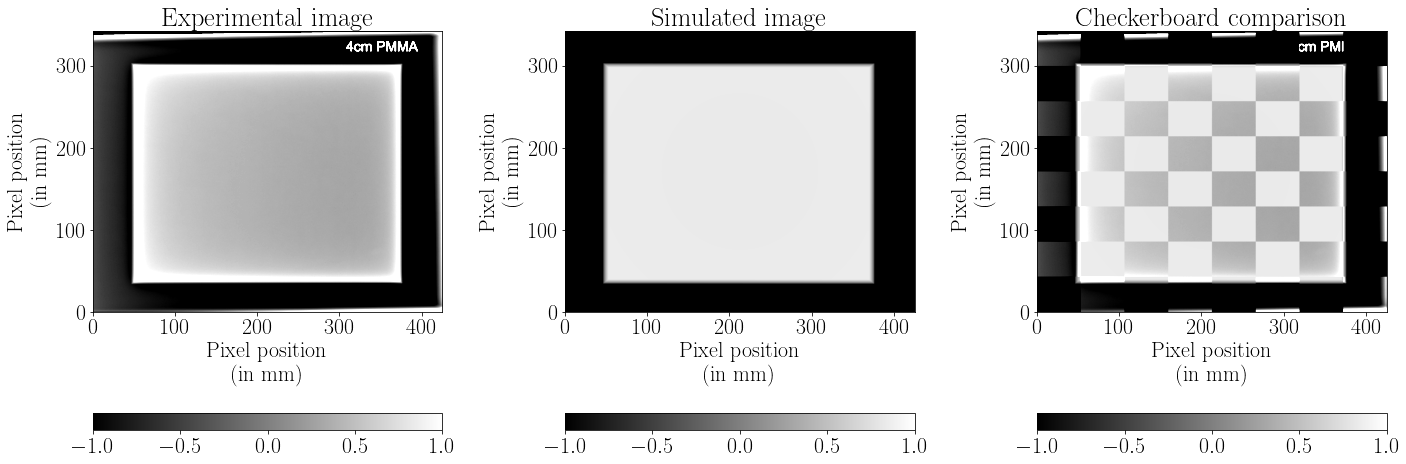

In [37]:
plt.figure(figsize= (20,10))
compareImages(real_image, x_ray_image)

In [38]:
def drawHorizontalProfiles(real_image, x_ray_image):

    horizontal_profile_real_image = real_image[real_image.shape[1] // 2]
    horizontal_profile_simulated_image = x_ray_image[x_ray_image.shape[1] // 2]

    x_val = np.linspace(0.0,
                        spacing[0] * real_image.shape[1],
                        real_image.shape[1], endpoint=True)

    plt.plot(x_val, horizontal_profile_real_image)
    plt.plot(x_val, horizontal_profile_simulated_image)

    plt.xlabel("Pixel position\n(in mm)")
    plt.ylabel("Relative intensity")

In [39]:
def drawVerticalProfiles(real_image, x_ray_image):
    vertical_profile_real_image = real_image[:,real_image.shape[0] // 2]
    vertical_profile_simulated_image = x_ray_image[:,x_ray_image.shape[0] // 2]

    x_val = np.linspace(0.0,
                        spacing[1] * real_image.shape[0],
                        real_image.shape[0], endpoint=True)

    plt.plot(x_val, vertical_profile_real_image)
    plt.plot(x_val, vertical_profile_simulated_image)

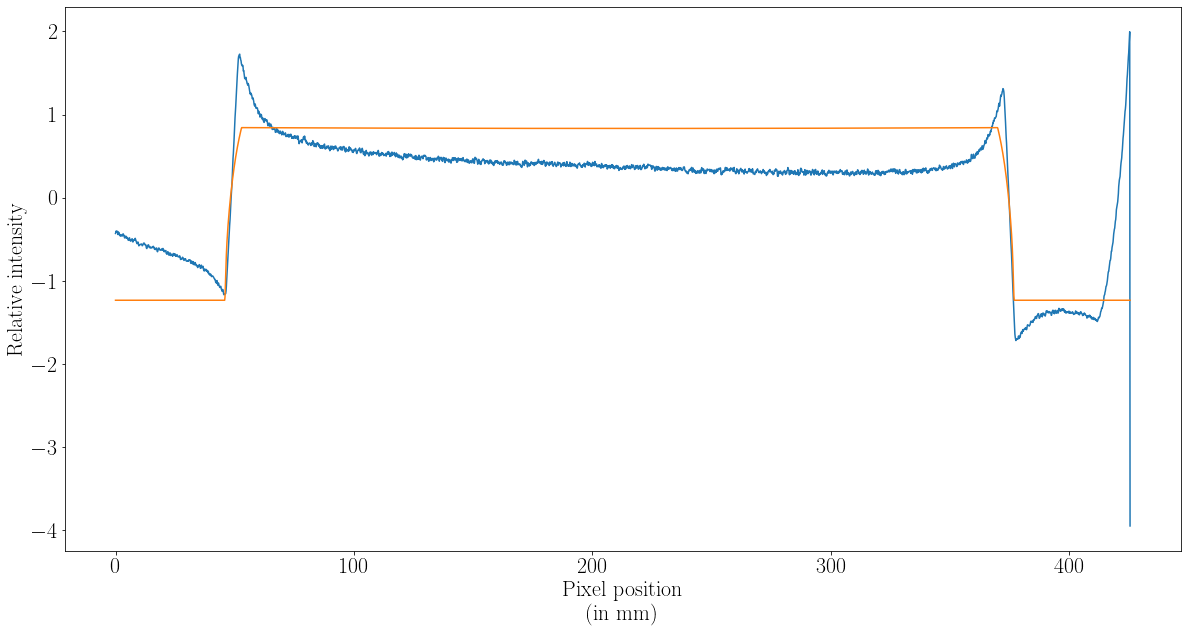

In [40]:
plt.figure(figsize= (20,10))
drawHorizontalProfiles(real_image, x_ray_image)

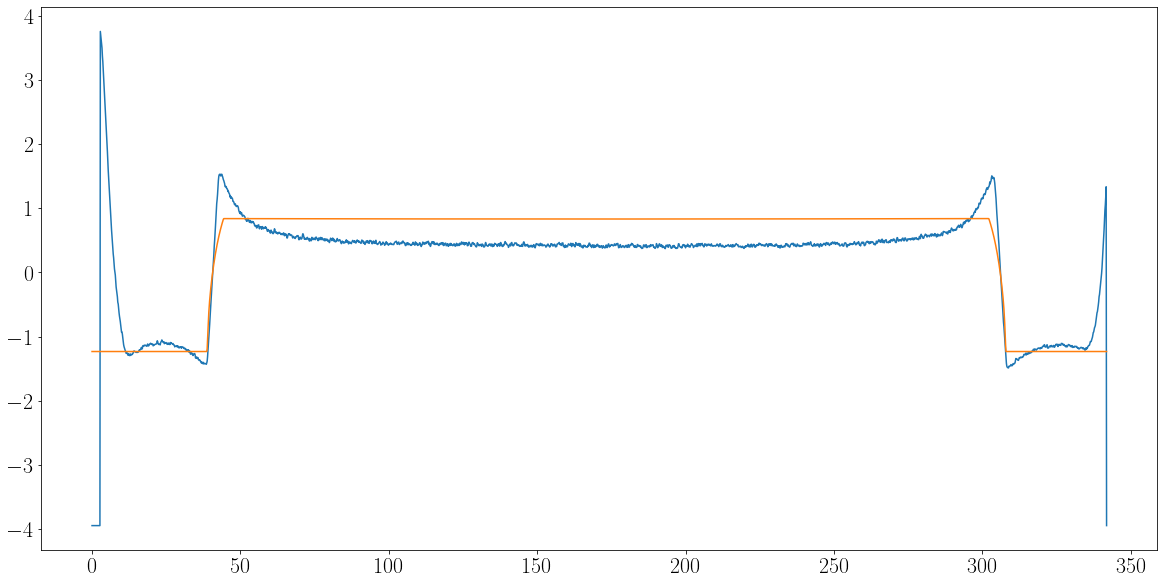

In [41]:
plt.figure(figsize= (20,10))
drawVerticalProfiles(real_image, x_ray_image)

In [42]:
def createAnimation(evolution_parameters, real_image):
    # Create the GIF file
    with imageio.get_writer("plots/evolution.gif", mode='I') as writer:

        # Store the PNG filenames
        png_filename_set = [];

        # Process all the images
        for i, [t, x, y, z, w, h, r] in enumerate(evolution_parameters):
            t = int(t)
            
            x_ray_image = imread("outputs/xray_" + str(i) + ".tif")
            screenshot = imread("outputs/screenshot_" + str(i) + ".tif")
            
            # Create the figure
            fig, axs = plt.subplots(nrows=2, ncols=3, figsize= (20,10))
            plt.suptitle("Iteration " + str(t+1) + "/" + str(int(evolution_parameters[-1][0]+1)))
            compareImages(real_image, x_ray_image, False, 2, 3)
      
            plt.subplot(234)
            drawHorizontalProfiles(real_image, x_ray_image)

            plt.subplot(235)
            drawVerticalProfiles(real_image, x_ray_image)
  

            plt.subplot(236)
            plt.imshow(screenshot)

            # Save the figure as a PNG file
            plt.savefig("temp.png")

            # Close the figure
            plt.close()

            # Open the PNG file with imageio and add it to the GIF file
            image = imageio.imread("temp.png")
            writer.append_data(image)

            # Delete the PNG file
            os.remove("temp.png");

        for i in range(15):
            writer.append_data(image)

<!-- ![](plots/evolution.gif) -->

In [43]:
createAnimation(evolution_parameters, real_image)

![GIF animation of the artificial evolution results](plots/evolution.gif)